In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

In [2]:
from bart_playground import *

In [3]:
notebook = "real3_CalHousing_init_noisy"

In [4]:
import numpy as np

from sklearn.datasets import fetch_california_housing

data = fetch_california_housing(as_frame=True)

X = data.data
y = data.target

X = X.values.astype(float)
y = np.array(y).reshape(-1)

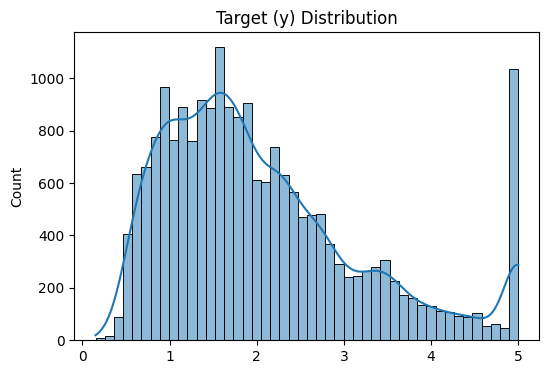

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

In [6]:
np.random.seed(42)
noise_level = 0.5
y = y + np.random.normal(0, noise_level, size=y.shape)

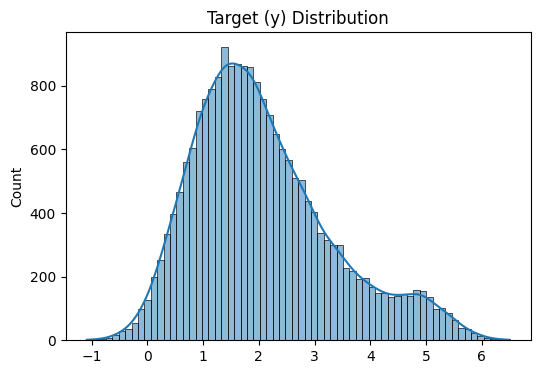

In [7]:
plt.figure(figsize=(6, 4))
sns.histplot(y, kde=True)
plt.title("Target (y) Distribution")
plt.show()

In [8]:
ndpost = 10000
nskip = 0
n_trees = 100

In [9]:
from experiment_init import run_parallel_experiments

# Run 4 parallel experiments
results = run_parallel_experiments(X, y, ndpost, nskip, n_trees, notebook, n_runs=4, n_jobs=4)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
Iterations: 100%|██████████| 10000/10000 [07:17<00:00, 22.83it/s]
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed: 60.1min
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed: 60.1min remaining: 60.1min
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed: 60.6min finished


In [9]:
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)

default_data = experiment_results['default'].item()
mtmh_data = experiment_results['mtmh'].item()
metadata = experiment_results['metadata'].item()

n_runs = metadata['n_runs']

# Trace Plots Analysis
## Tree Depth / #Leaves

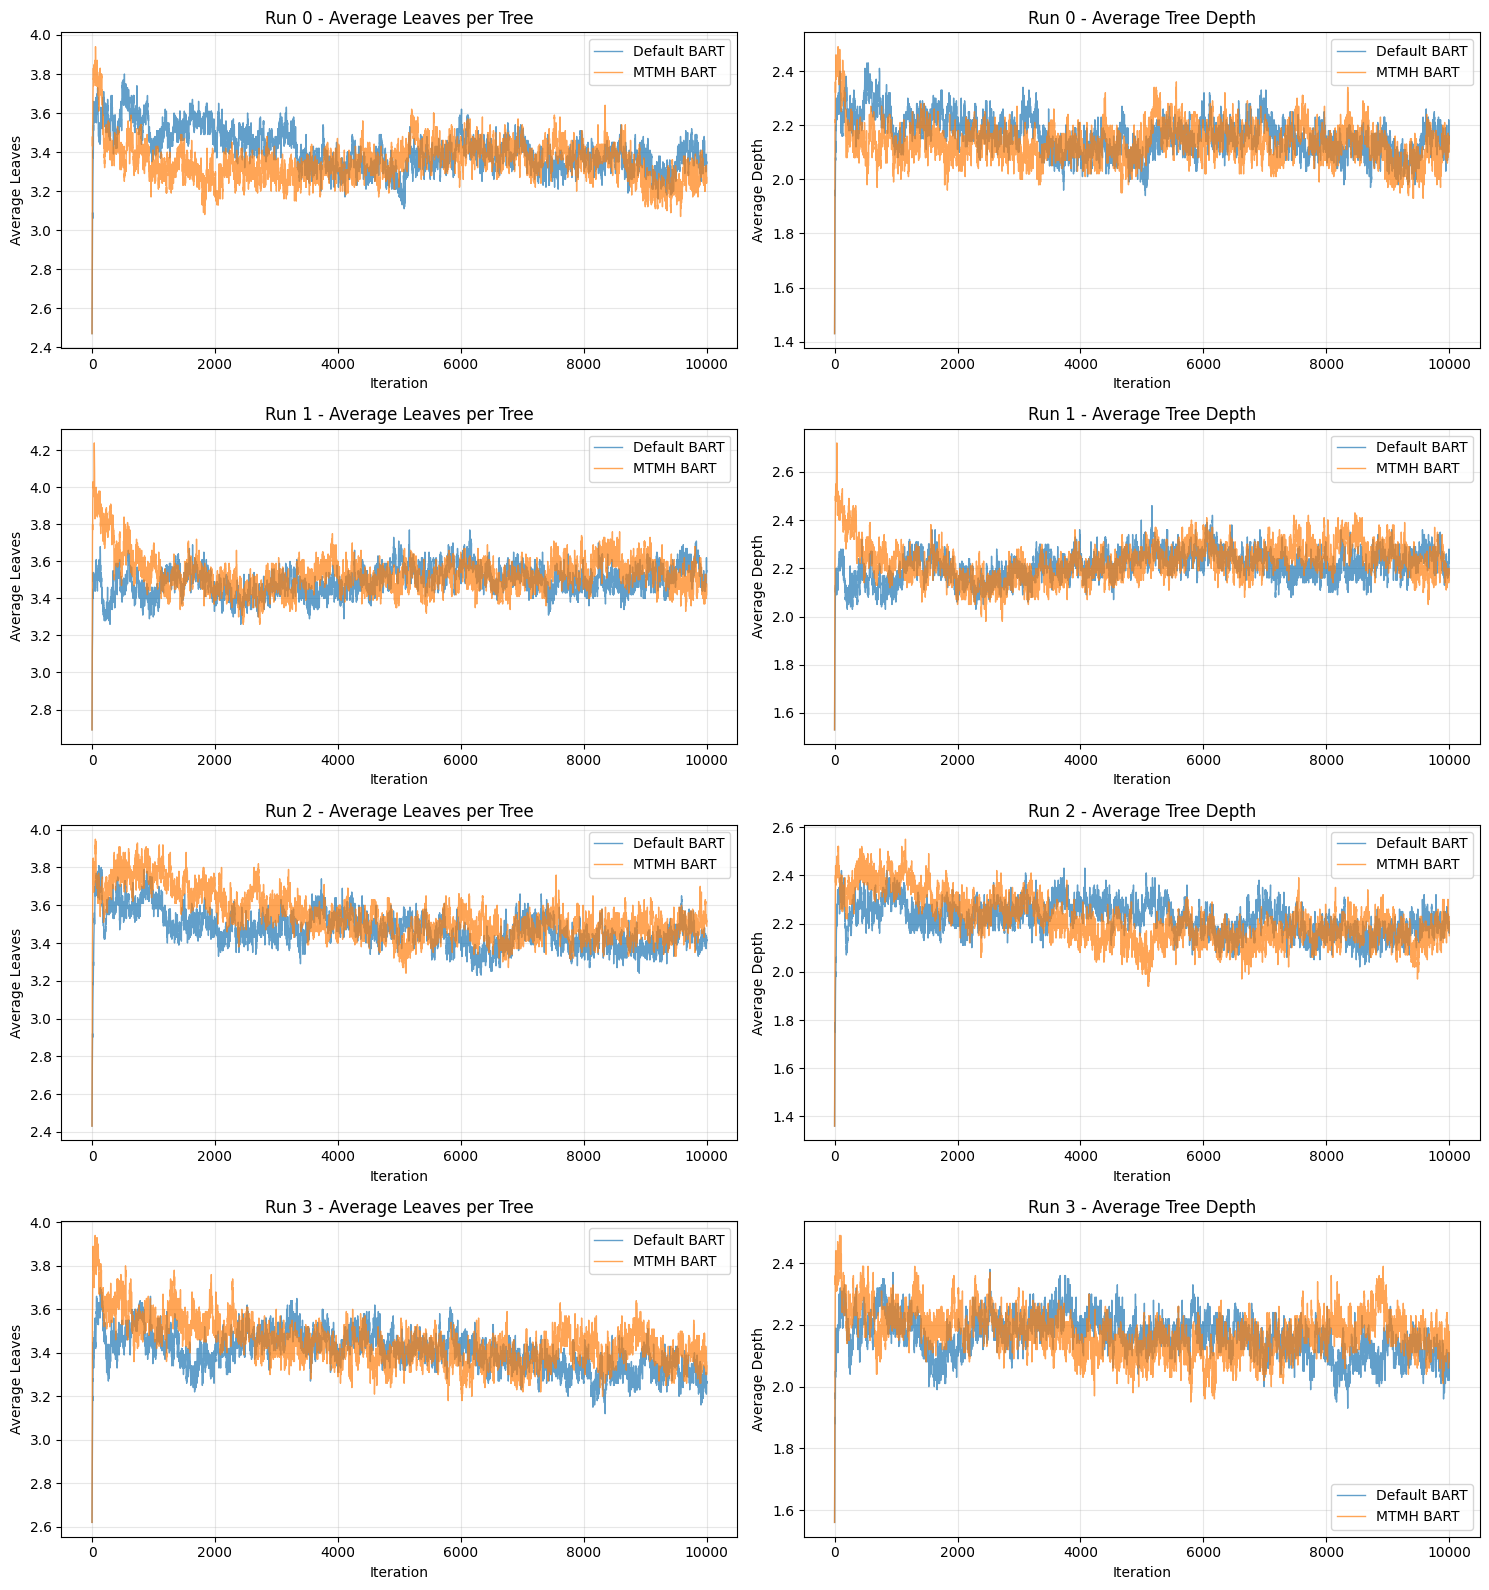

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Extract leaves and depths data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_leaves = experiment_results['default'].item()['leaves'][run_id]
    mtmh_leaves = experiment_results['mtmh'].item()['leaves'][run_id]
    default_depths = experiment_results['default'].item()['depths'][run_id]
    mtmh_depths = experiment_results['mtmh'].item()['depths'][run_id]
    
    # Plot leaves (left column)
    axes[run_id, 0].plot(default_leaves, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_leaves, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Average Leaves per Tree')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Average Leaves')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot depths (right column)
    axes[run_id, 1].plot(default_depths, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_depths, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - Average Tree Depth')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Average Depth')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

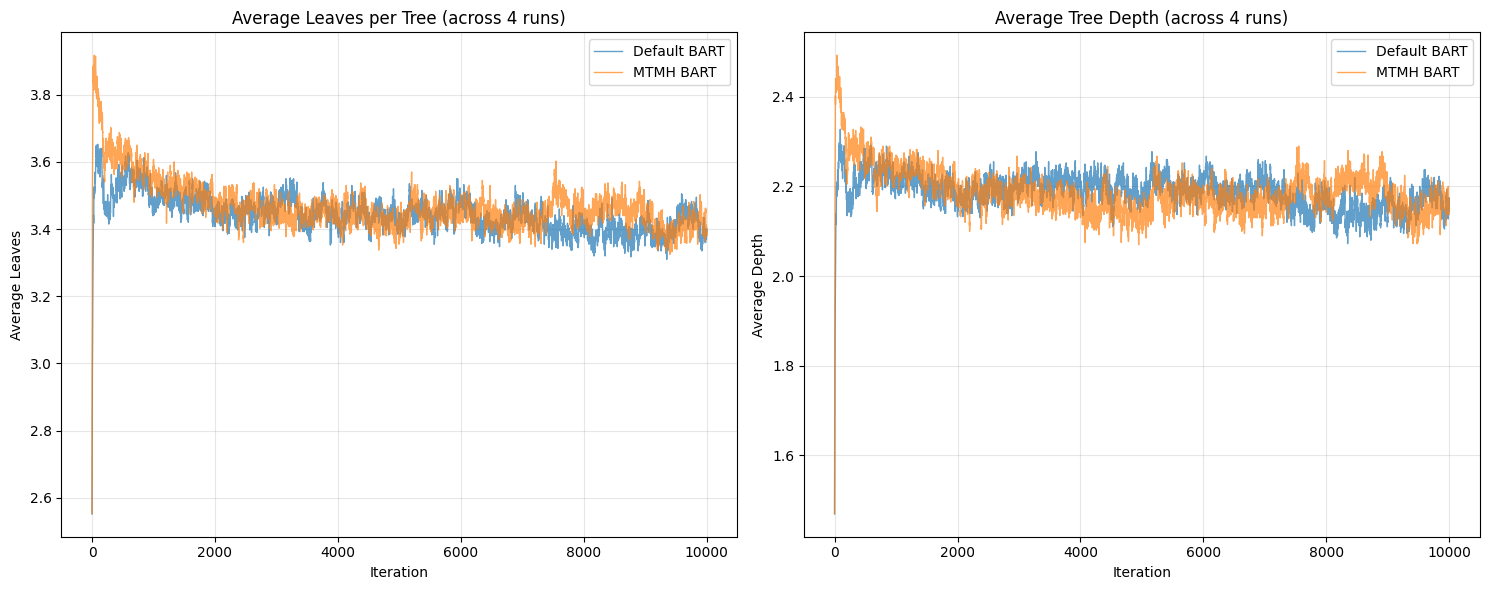

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_leaves_all = []
mtmh_leaves_all = []
default_depths_all = []
mtmh_depths_all = []

for run_id in range(n_runs):
    default_leaves_all.append(experiment_results['default'].item()['leaves'][run_id])
    mtmh_leaves_all.append(experiment_results['mtmh'].item()['leaves'][run_id])
    default_depths_all.append(experiment_results['default'].item()['depths'][run_id])
    mtmh_depths_all.append(experiment_results['mtmh'].item()['depths'][run_id])

# Convert to numpy arrays
default_leaves_all = np.array(default_leaves_all)  # Shape: (n_runs, n_iterations)
mtmh_leaves_all = np.array(mtmh_leaves_all)
default_depths_all = np.array(default_depths_all)
mtmh_depths_all = np.array(mtmh_depths_all)

# Calculate mean and std across runs
default_leaves_mean = np.mean(default_leaves_all, axis=0)
mtmh_leaves_mean = np.mean(mtmh_leaves_all, axis=0)

default_depths_mean = np.mean(default_depths_all, axis=0)
mtmh_depths_mean = np.mean(mtmh_depths_all, axis=0)

# Create iteration axis
iterations = np.arange(len(default_leaves_mean))

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot leaves
ax1.plot(iterations, default_leaves_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_leaves_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Average Leaves per Tree (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Average Leaves')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot depths
ax2.plot(iterations, default_depths_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_depths_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'Average Tree Depth (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('Average Depth')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Sigmas & RMSE

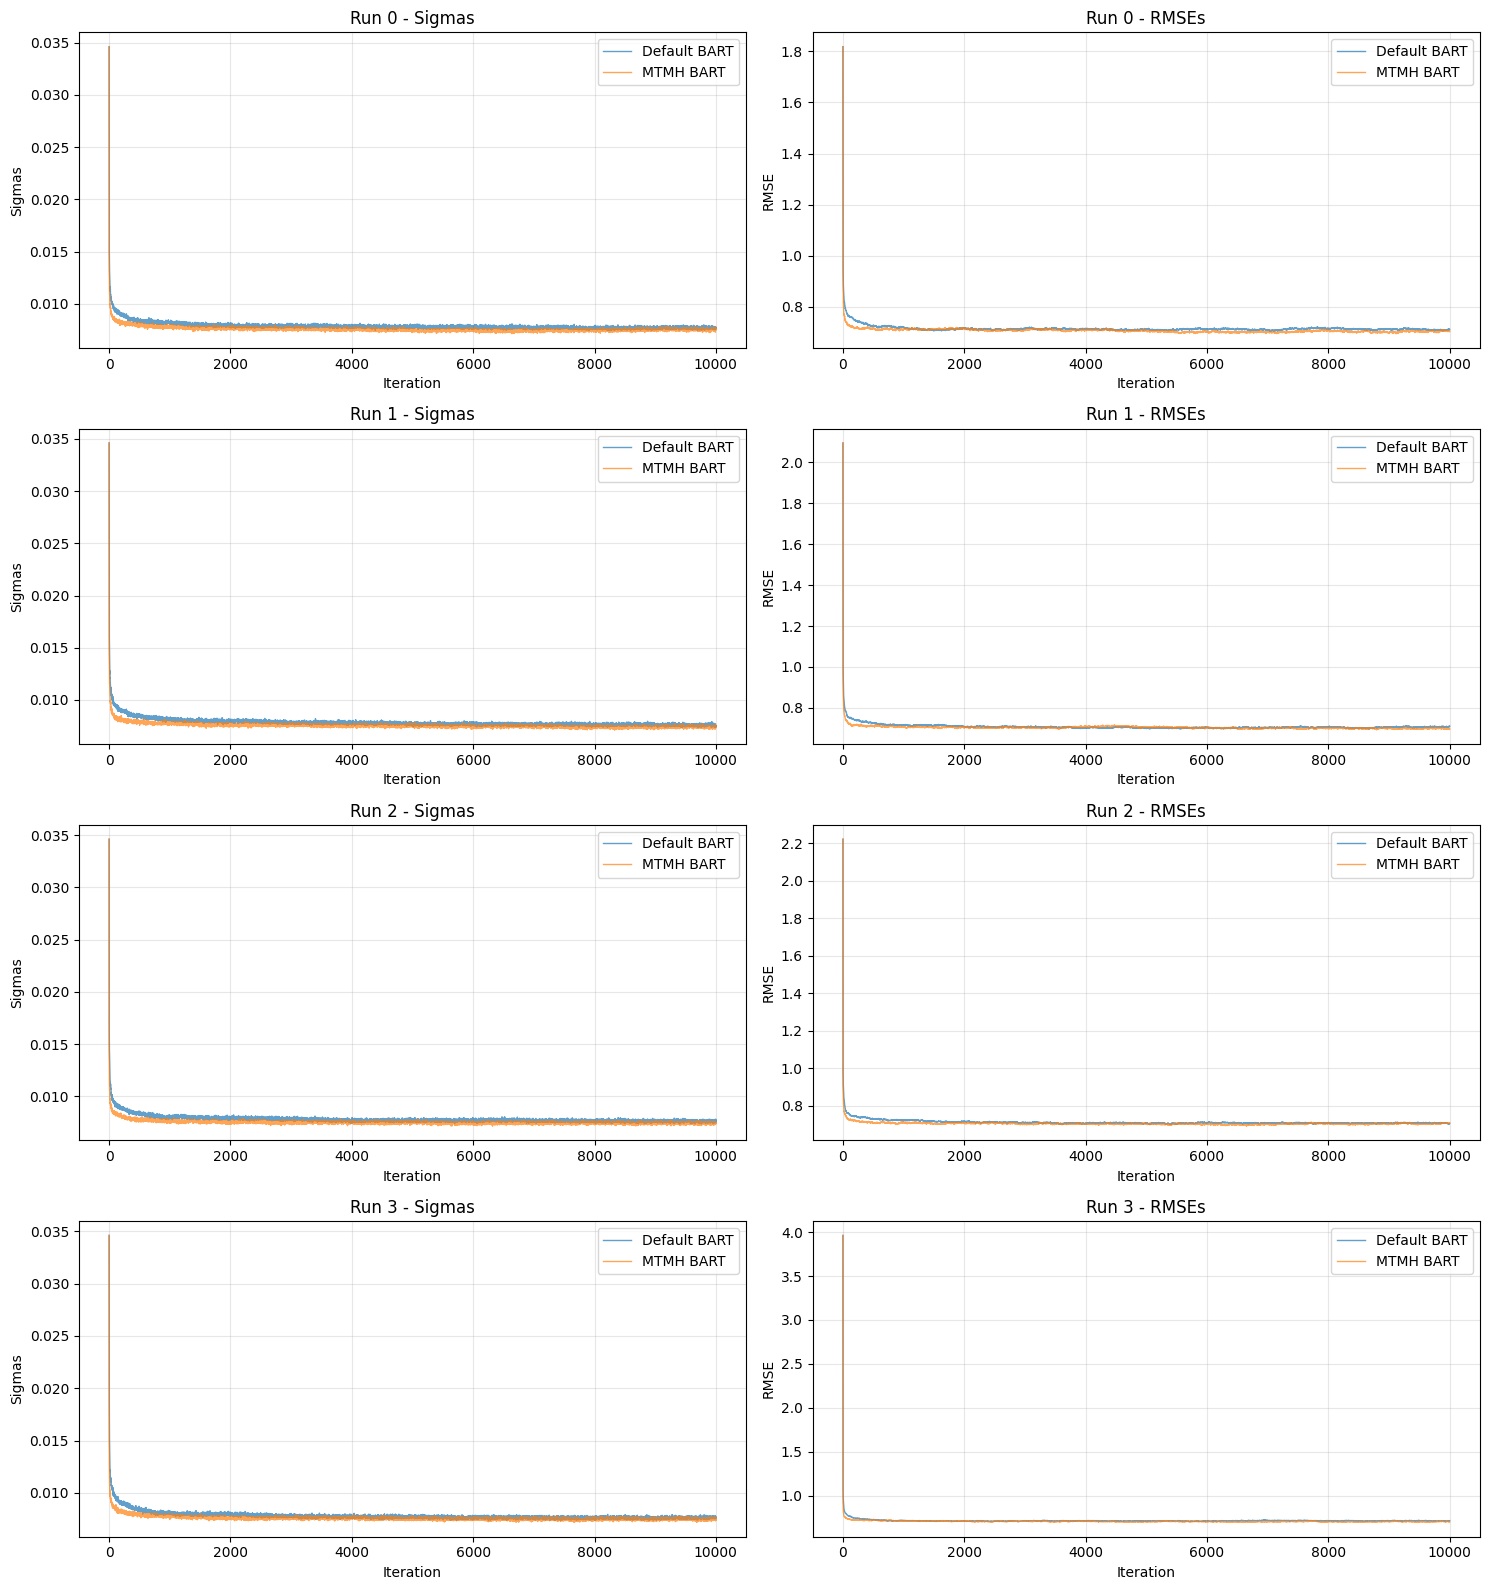

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    default_rmses = experiment_results['default'].item()['rmses'][run_id]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses, label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses, label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

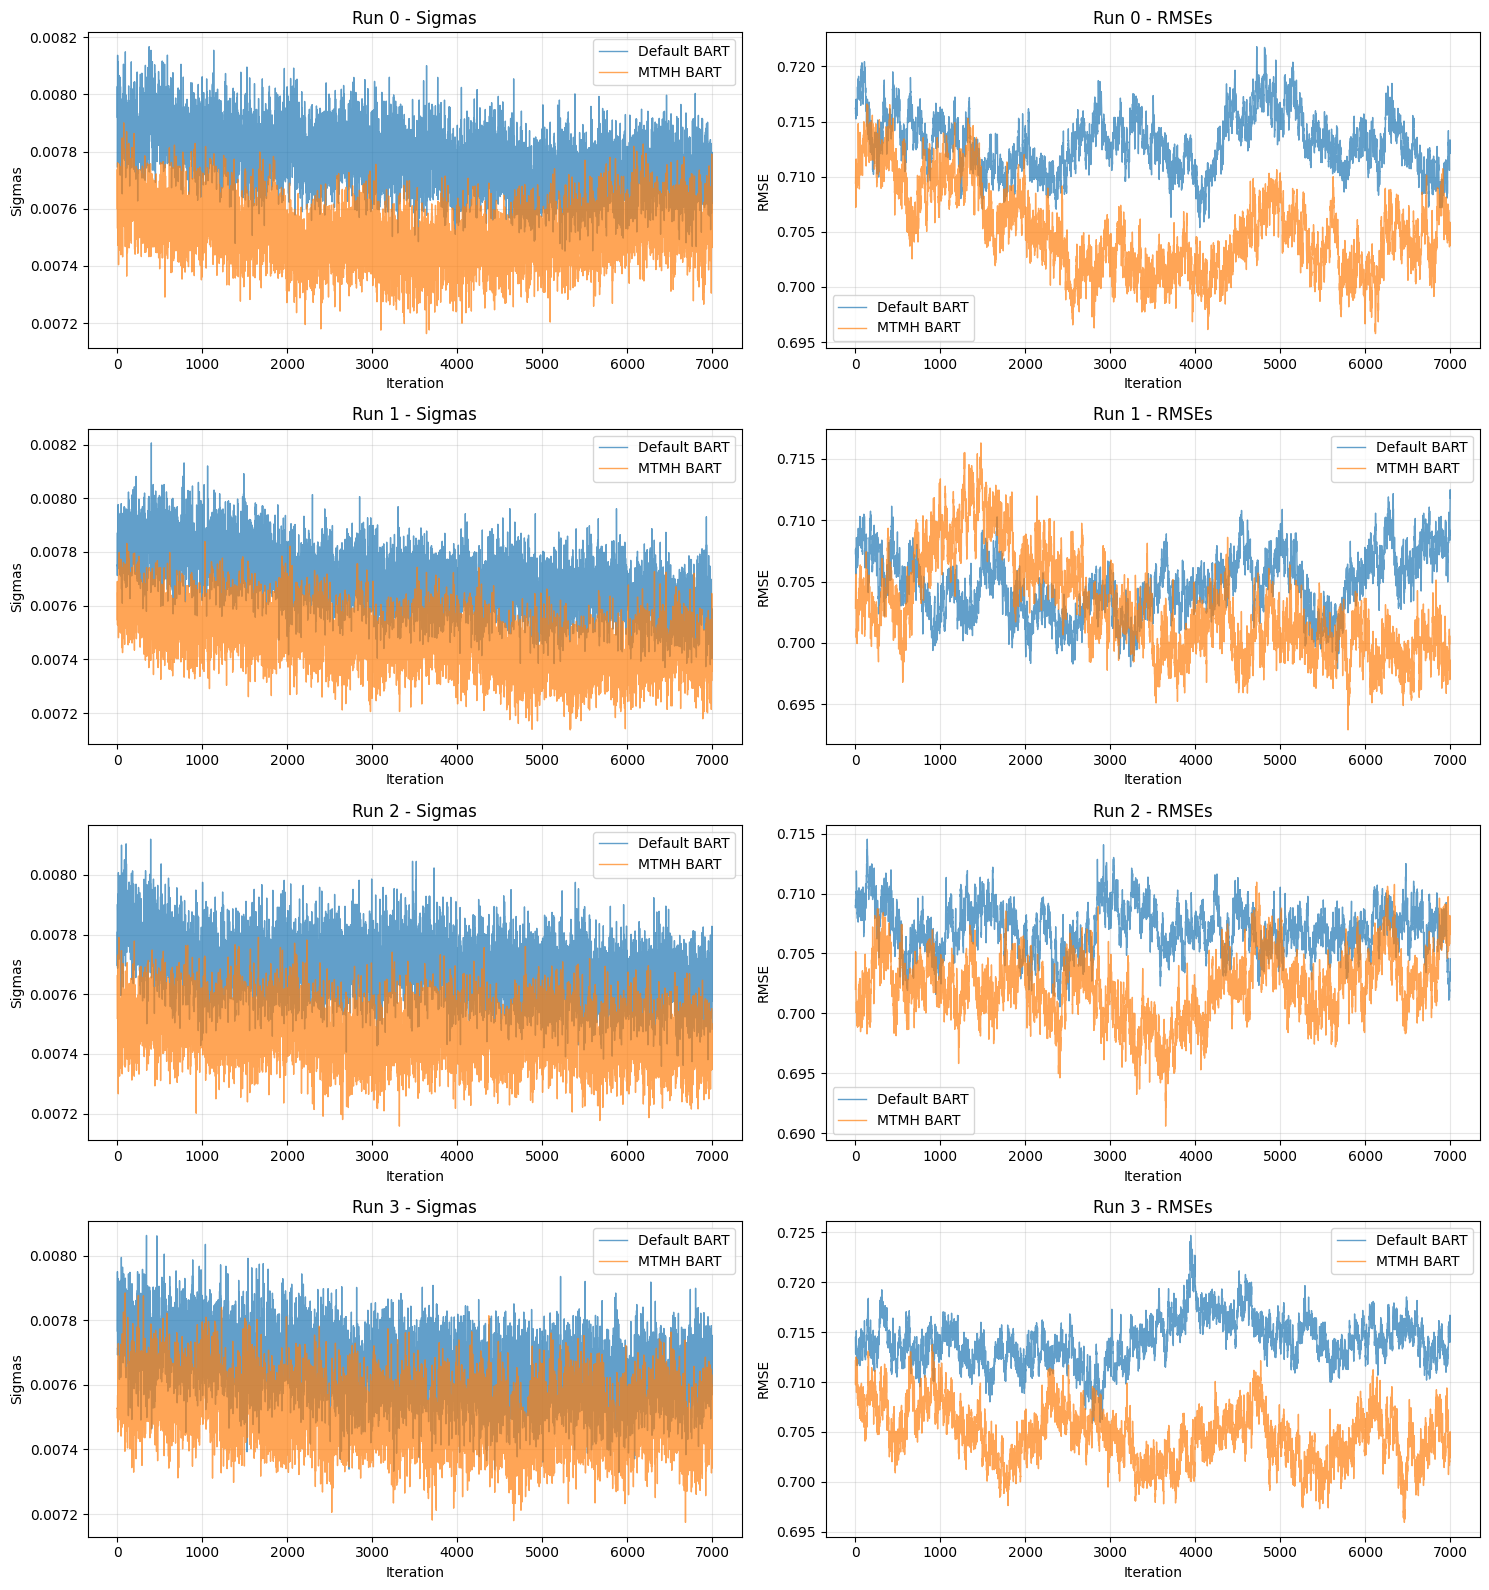

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Extract sigmas and rmses data for visualization
n_runs = experiment_results['metadata'].item()['n_runs']

fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

for run_id in range(n_runs):
    # Extract data for this run
    default_sigmas = experiment_results['default'].item()['sigmas'][run_id]
    mtmh_sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    default_rmses = experiment_results['default'].item()['rmses'][run_id]
    mtmh_rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    # Plot sigmas (left column)
    axes[run_id, 0].plot(default_sigmas[3000:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].plot(mtmh_sigmas[3000:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 0].set_title(f'Run {run_id} - Sigmas')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigmas')
    axes[run_id, 0].legend()
    axes[run_id, 0].grid(True, alpha=0.3)

    # Plot rmses (right column)
    axes[run_id, 1].plot(default_rmses[3000:], label='Default BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].plot(mtmh_rmses[3000:], label='MTMH BART', alpha=0.7, linewidth=1)
    axes[run_id, 1].set_title(f'Run {run_id} - RMSEs')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('RMSE')
    axes[run_id, 1].legend()
    axes[run_id, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

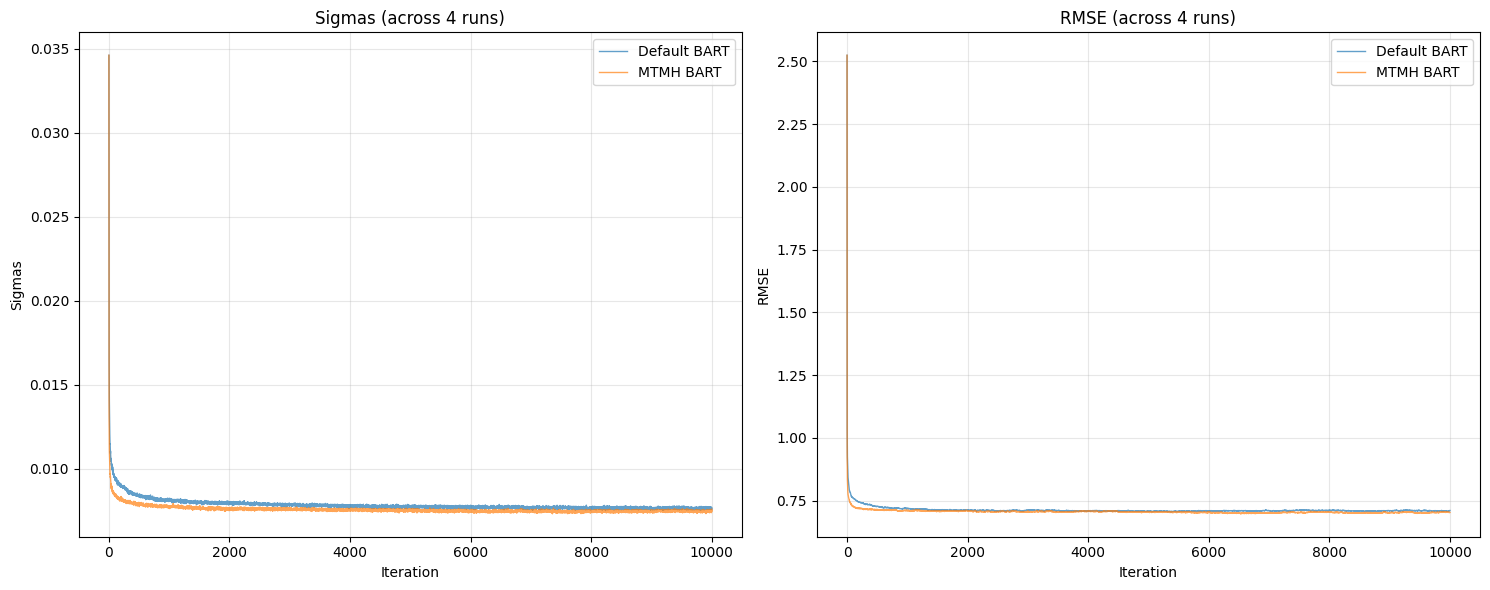

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data across all runs
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect all runs data
default_sigmas_all = []
mtmh_sigmas_all = []
default_rmses_all = []
mtmh_rmses_all = []

for run_id in range(n_runs):
    default_sigmas_all.append(experiment_results['default'].item()['sigmas'][run_id])
    mtmh_sigmas_all.append(experiment_results['mtmh'].item()['sigmas'][run_id])
    default_rmses_all.append(experiment_results['default'].item()['rmses'][run_id])
    mtmh_rmses_all.append(experiment_results['mtmh'].item()['rmses'][run_id])

# Convert to numpy arrays
default_sigmas_all = np.array(default_sigmas_all)  # Shape: (n_runs, n_iterations)
mtmh_sigmas_all = np.array(mtmh_sigmas_all)
default_rmses_all = np.array(default_rmses_all)
mtmh_rmses_all = np.array(mtmh_rmses_all)

# Calculate mean and std across runs
default_sigmas_mean = np.mean(default_sigmas_all, axis=0)
mtmh_sigmas_mean = np.mean(mtmh_sigmas_all, axis=0)

default_rmses_mean = np.mean(default_rmses_all, axis=0)
mtmh_rmses_mean = np.mean(mtmh_rmses_all, axis=0)

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

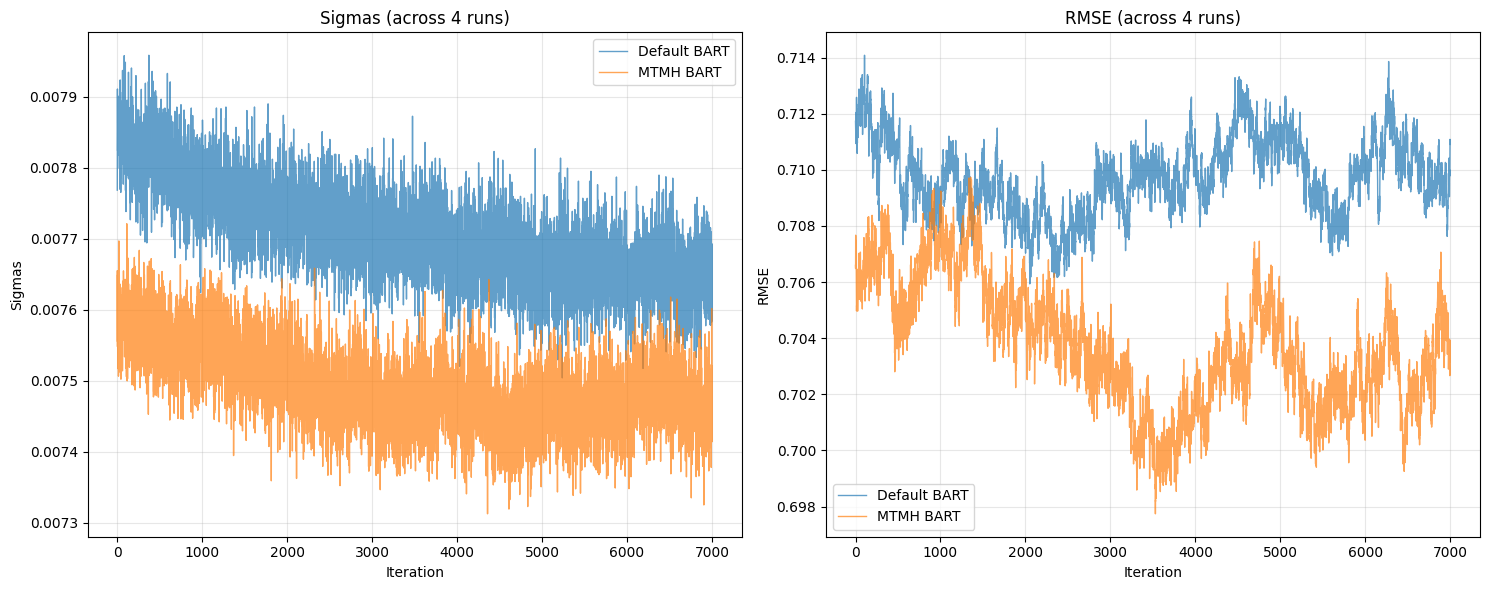

In [16]:
# Extract data after burn-in
default_sigmas_mean = default_sigmas_mean[3000:]
mtmh_sigmas_mean = mtmh_sigmas_mean[3000:]

default_rmses_mean = default_rmses_mean[3000:]
mtmh_rmses_mean = mtmh_rmses_mean[3000:]

# Plot averaged results with error bands
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot sigmas
iterations = np.arange(len(default_sigmas_mean))
ax1.plot(iterations, default_sigmas_mean, label='Default BART', alpha=0.7, linewidth=1)
ax1.plot(iterations, mtmh_sigmas_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax1.set_title(f'Sigmas (across {n_runs} runs)')
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Sigmas')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rmses
iterations = np.arange(len(default_rmses_mean))
ax2.plot(iterations, default_rmses_mean, label='Default BART', alpha=0.7, linewidth=1)
ax2.plot(iterations, mtmh_rmses_mean, label='MTMH BART', alpha=0.7, linewidth=1)
ax2.set_title(f'RMSE (across {n_runs} runs)')
ax2.set_xlabel('Iteration')
ax2.set_ylabel('RMSE')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Convergence Analysis
## KPSS test

In [10]:
from diagnosis import segmented_kpss_test

=== Default BART Analysis ===

--- Default Run 0 ---
Sigma convergence analysis:


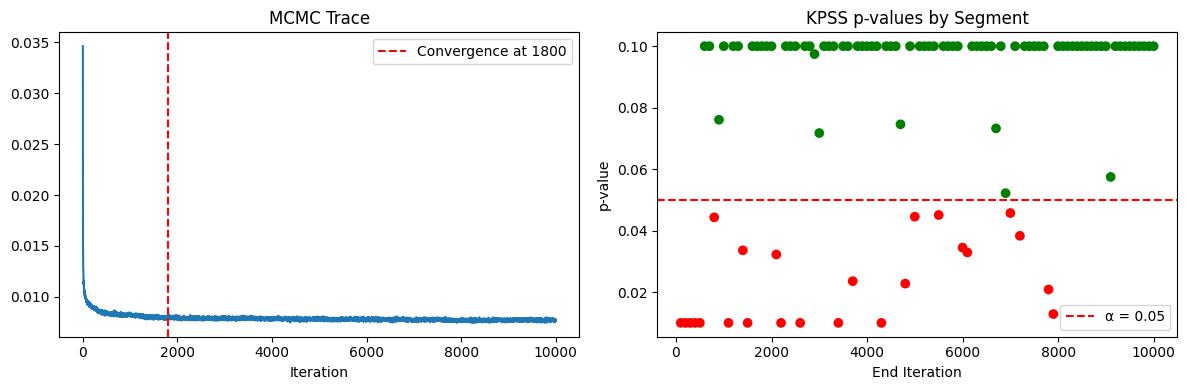

Default Chain converged: True
Convergence at iteration: 1800
Convergence rate: 76.00%

RMSE convergence analysis:


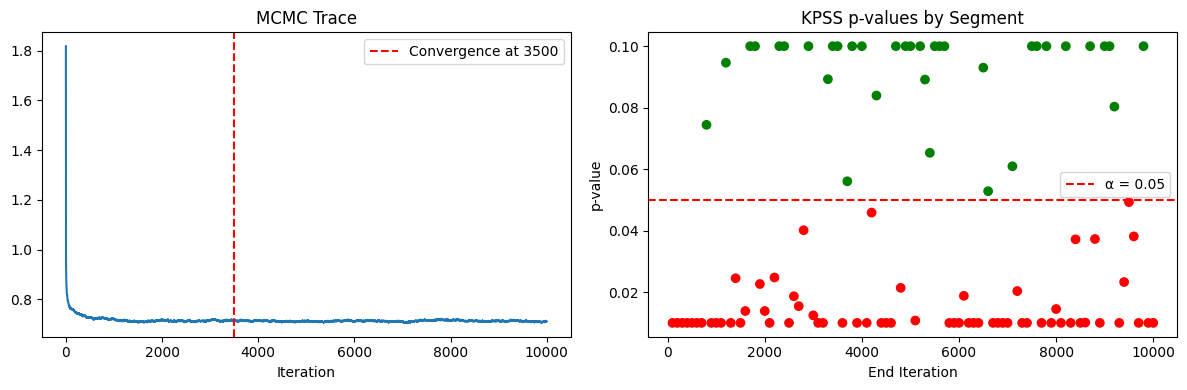

Default Chain converged: True
Convergence at iteration: 3500
Convergence rate: 35.00%

--- Default Run 1 ---
Sigma convergence analysis:


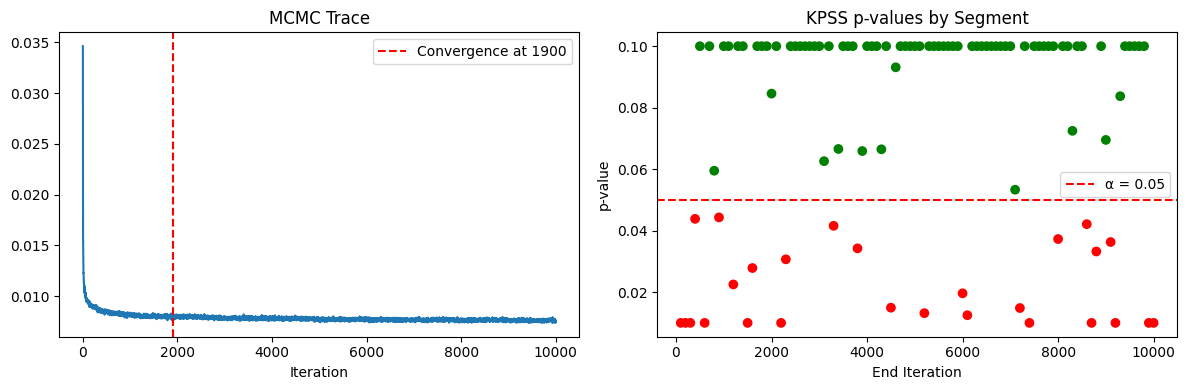

Default Chain converged: True
Convergence at iteration: 1900
Convergence rate: 73.00%

RMSE convergence analysis:


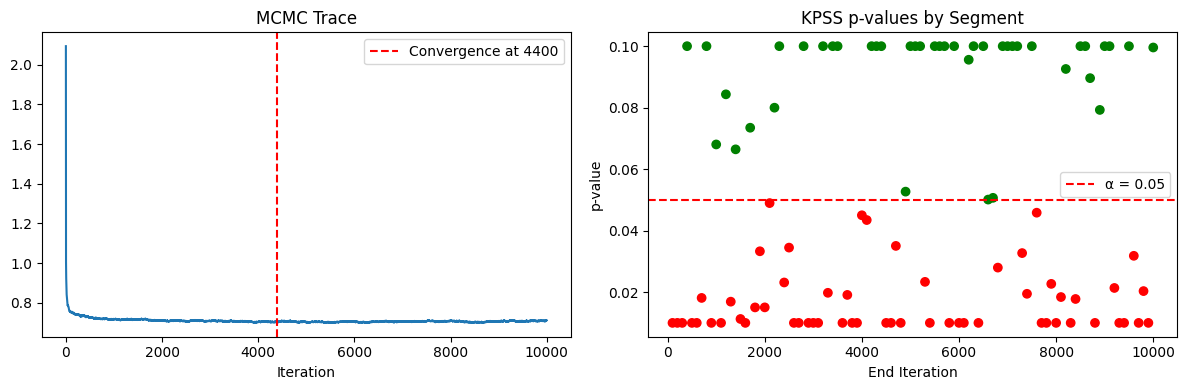

Default Chain converged: True
Convergence at iteration: 4400
Convergence rate: 42.00%

--- Default Run 2 ---
Sigma convergence analysis:


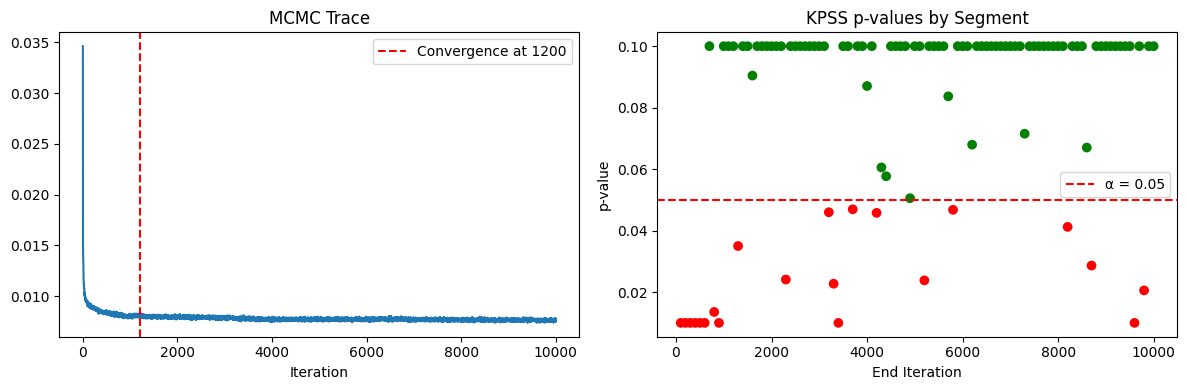

Default Chain converged: True
Convergence at iteration: 1200
Convergence rate: 79.00%

RMSE convergence analysis:


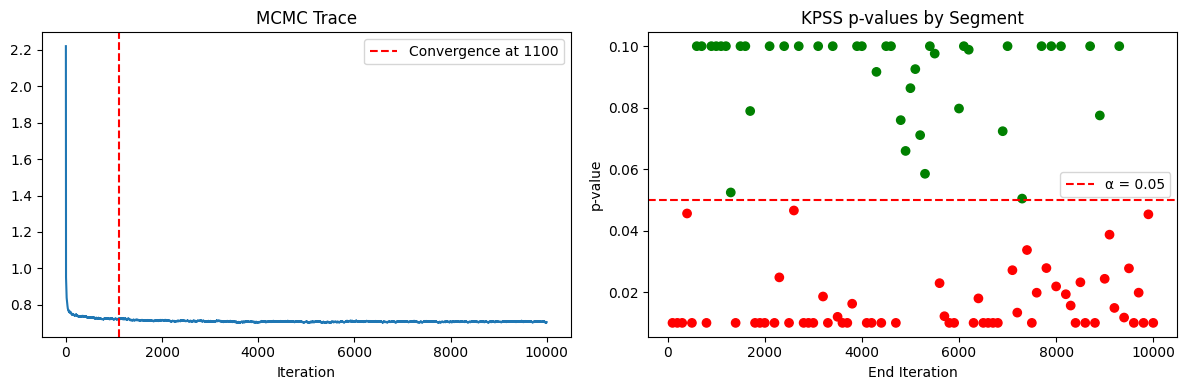

Default Chain converged: True
Convergence at iteration: 1100
Convergence rate: 40.00%

--- Default Run 3 ---
Sigma convergence analysis:


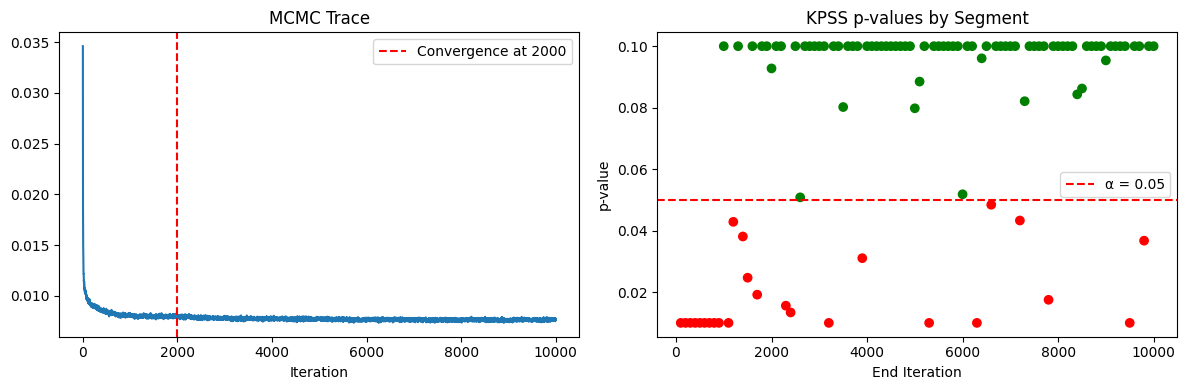

Default Chain converged: True
Convergence at iteration: 2000
Convergence rate: 75.00%

RMSE convergence analysis:


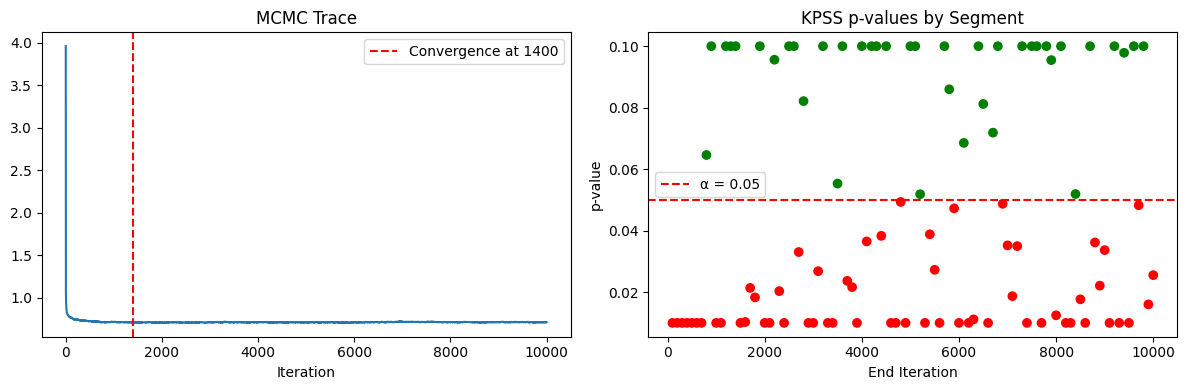

Default Chain converged: True
Convergence at iteration: 1400
Convergence rate: 39.00%


In [11]:
# Analyze each run's results and collect statistics
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect convergence statistics
default_sigma_convergence = []
default_rmse_convergence = []
default_sigma_rates = []
default_rmse_rates = []

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Default Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['default'].item()['sigmas'][run_id]
    rmses = experiment_results['default'].item()['rmses'][run_id]
    
    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"Default Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_sigma_rates.append(convergence_result['convergence_rate'])
    
    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"Default Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    default_rmse_rates.append(convergence_result['convergence_rate'])

=== MTMH BART Analysis ===

--- MTMH Run 0 ---
Sigma convergence analysis:


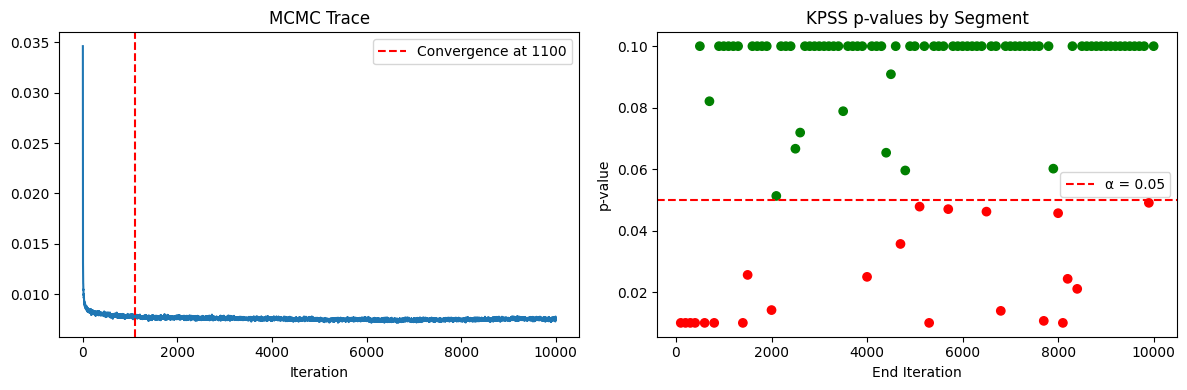

MTMH Chain converged: True
Convergence at iteration: 1100
Convergence rate: 78.00%

RMSE convergence analysis:


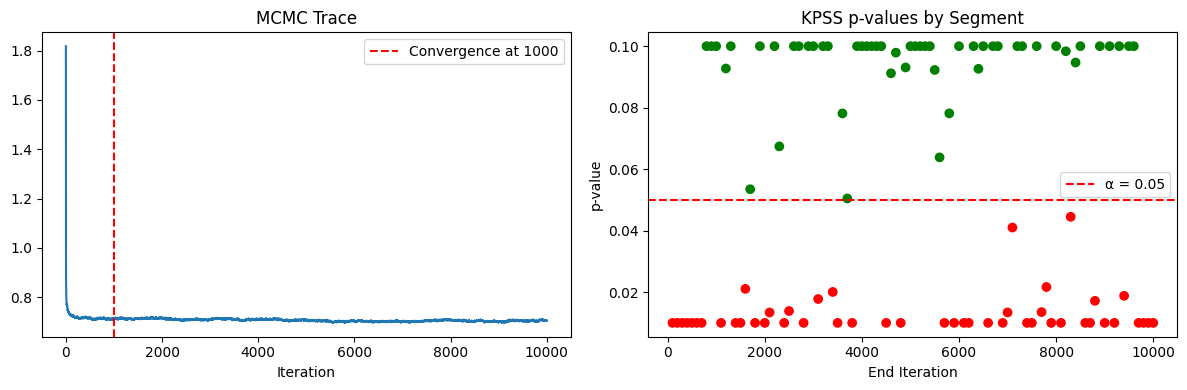

MTMH Chain converged: True
Convergence at iteration: 1000
Convergence rate: 52.00%

--- MTMH Run 1 ---
Sigma convergence analysis:


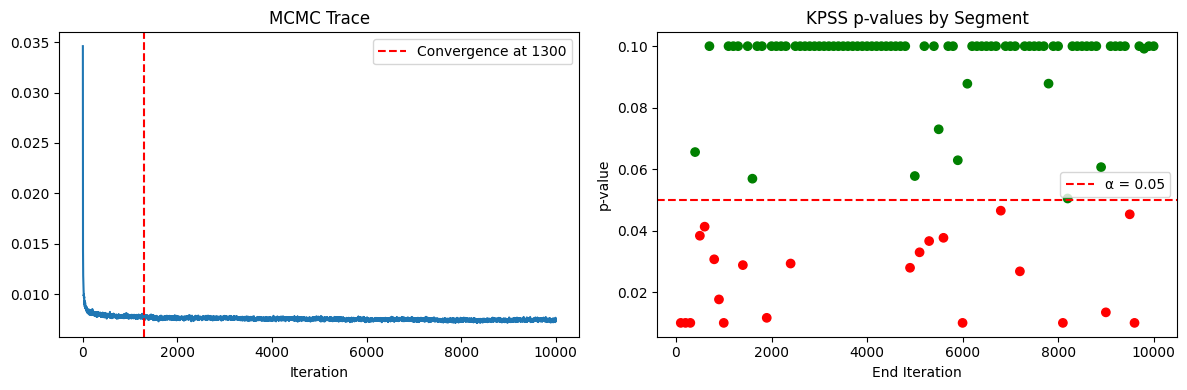

MTMH Chain converged: True
Convergence at iteration: 1300
Convergence rate: 78.00%

RMSE convergence analysis:


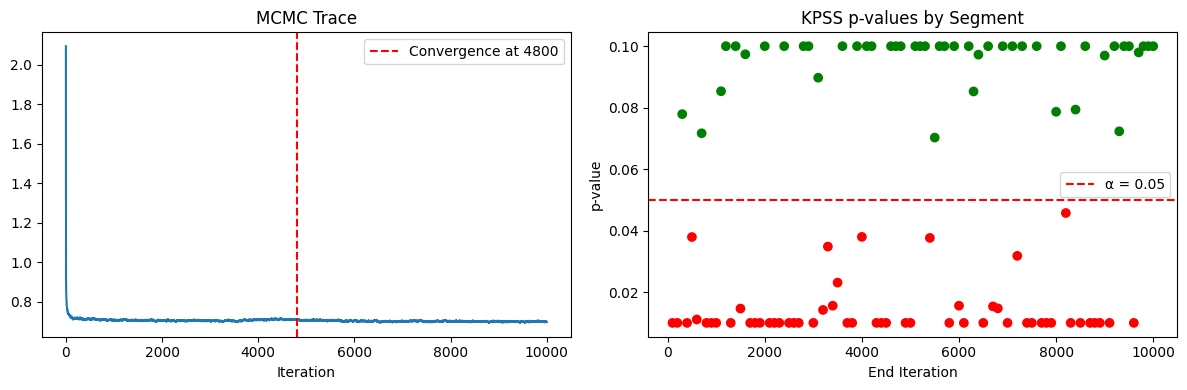

MTMH Chain converged: True
Convergence at iteration: 4800
Convergence rate: 46.00%

--- MTMH Run 2 ---
Sigma convergence analysis:


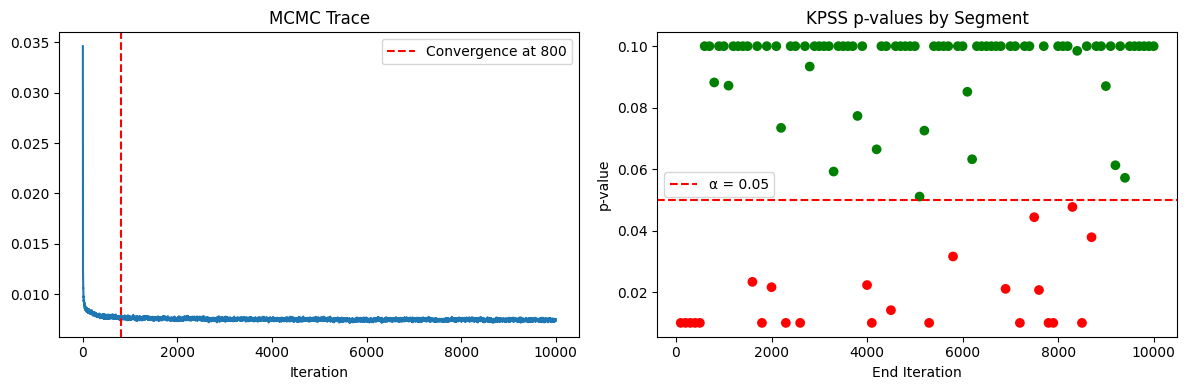

MTMH Chain converged: True
Convergence at iteration: 800
Convergence rate: 76.00%

RMSE convergence analysis:


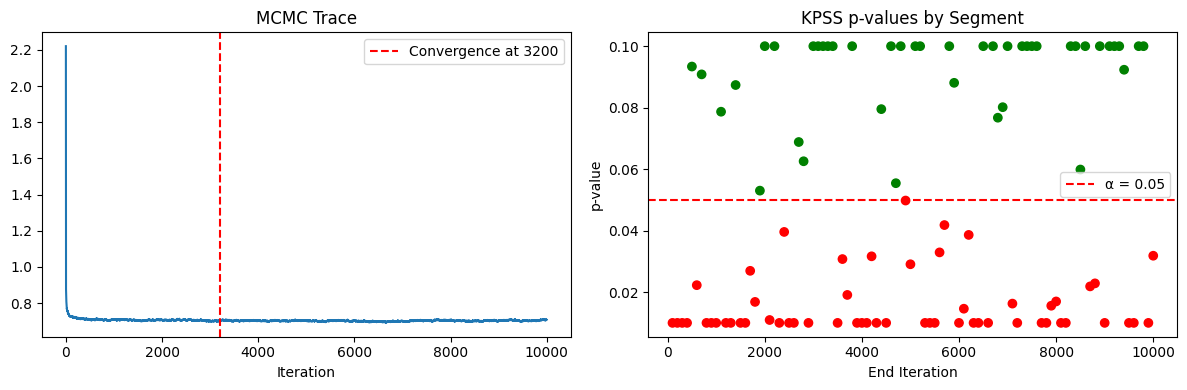

MTMH Chain converged: True
Convergence at iteration: 3200
Convergence rate: 43.00%

--- MTMH Run 3 ---
Sigma convergence analysis:


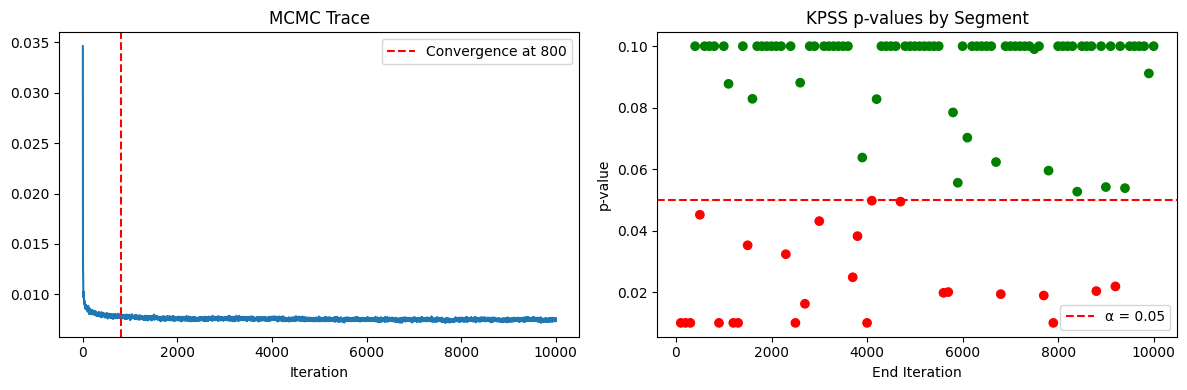

MTMH Chain converged: True
Convergence at iteration: 800
Convergence rate: 76.00%

RMSE convergence analysis:


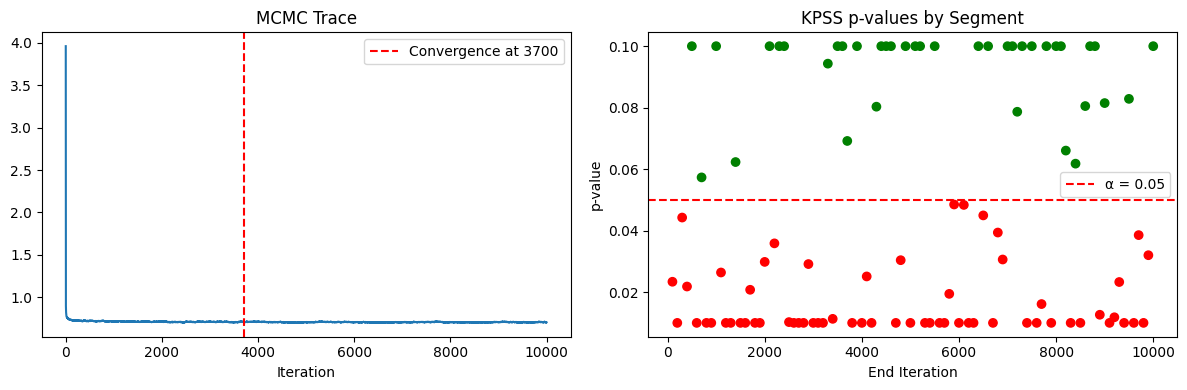

MTMH Chain converged: True
Convergence at iteration: 3700
Convergence rate: 38.00%


In [12]:
# Collect convergence statistics
mtmh_sigma_convergence = []
mtmh_rmse_convergence = []
mtmh_sigma_rates = []
mtmh_rmse_rates = []

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- MTMH Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, segment_length=100)
    print(f"MTMH Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_sigma_rates.append(convergence_result['convergence_rate'])

    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, segment_length=100)
    print(f"MTMH Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Convergence rate: {convergence_result['convergence_rate']:.2%}")
    mtmh_rmse_rates.append(convergence_result['convergence_rate'])

In [13]:
# Print summary statistics for Default BART
print("\n=== Default BART Summary ===")
if default_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(default_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(default_sigma_rates):.2%}")

if default_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(default_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(default_rmse_rates):.2%}")


=== Default BART Summary ===
Sigma - Average convergence iteration: 1725
Sigma - Average convergence rate: 75.75%
RMSE - Average convergence iteration: 2600
RMSE - Average convergence rate: 39.00%


In [14]:
# Print summary statistics for MTMH BART
print("\n=== MTMH BART Summary ===")
if mtmh_sigma_convergence:
    print(f"Sigma - Average convergence iteration: {np.mean(mtmh_sigma_convergence):.0f}")
else:
    print("Sigma - No convergence detected")
print(f"Sigma - Average convergence rate: {np.mean(mtmh_sigma_rates):.2%}")

if mtmh_rmse_convergence:
    print(f"RMSE - Average convergence iteration: {np.mean(mtmh_rmse_convergence):.0f}")
else:
    print("RMSE - No convergence detected")
print(f"RMSE - Average convergence rate: {np.mean(mtmh_rmse_rates):.2%}")


=== MTMH BART Summary ===
Sigma - Average convergence iteration: 1000
Sigma - Average convergence rate: 77.00%
RMSE - Average convergence iteration: 3175
RMSE - Average convergence rate: 44.75%


## ESS

In [ ]:
# Add logging configuration before importing arviz
import logging
logging.getLogger('arviz.preview').setLevel(logging.WARNING)
import arviz as az

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Extract prediction data for ESS analysis
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect ESS values for each test data point across all runs
default_ess_per_point = []
mtmh_ess_per_point = []

print("=== Prediction ESS Analysis ===")

for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract prediction data for this run (shape: n_test_samples x n_iterations)
    default_preds = experiment_results['default'].item()['preds'][run_id]
    mtmh_preds = experiment_results['mtmh'].item()['preds'][run_id]
    
    # Remove burn-in period (first 3000 iterations)
    default_preds_burnin = default_preds[:, 3000:]  # Shape: n_test_samples x (n_iterations - 3000)
    mtmh_preds_burnin = mtmh_preds[:, 3000:]
    
    # Calculate ESS for each test data point
    default_ess_run = []
    mtmh_ess_run = []
    
    n_test_samples = default_preds_burnin.shape[0]
    
    for i in range(n_test_samples):
        # ESS for each test point's prediction trace
        default_ess = az.ess(default_preds_burnin[i].reshape(1, -1), relative=True).item()
        mtmh_ess = az.ess(mtmh_preds_burnin[i].reshape(1, -1), relative=True).item()
        
        default_ess_run.append(default_ess)
        mtmh_ess_run.append(mtmh_ess)
    
    default_ess_per_point.append(default_ess_run)
    mtmh_ess_per_point.append(mtmh_ess_run)
    
    print(f"Default BART - Mean ESS: {np.mean(default_ess_run):.4f}, Std ESS: {np.std(default_ess_run):.4f}")
    print(f"MTMH BART - Mean ESS: {np.mean(mtmh_ess_run):.4f}, Std ESS: {np.std(mtmh_ess_run):.4f}")

# Convert to numpy arrays for easier manipulation
default_ess_per_point = np.array(default_ess_per_point)  # Shape: (n_runs, n_test_samples)
mtmh_ess_per_point = np.array(mtmh_ess_per_point)

print(f"\nOverall across all runs:")
print(f"Default BART - Mean ESS: {np.mean(default_ess_per_point):.4f}, Std ESS: {np.std(default_ess_per_point):.4f}")
print(f"MTMH BART - Mean ESS: {np.mean(mtmh_ess_per_point):.4f}, Std ESS: {np.std(mtmh_ess_per_point):.4f}")

In [ ]:
# Plot ESS comparison for each test data point using scatter plots
fig, axes = plt.subplots(n_runs, 1, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = [axes]

for run_id in range(n_runs):
    x = np.arange(len(default_ess_per_point[run_id]))
    
    axes[run_id].scatter(x, default_ess_per_point[run_id], 
                        label='Default BART', alpha=0.7, s=10)
    axes[run_id].scatter(x, mtmh_ess_per_point[run_id], 
                        label='MTMH BART', alpha=0.7, s=10)

    axes[run_id].set_title(f'Run {run_id} - ESS per Test Data Point')
    axes[run_id].set_xlabel('Test Data Point Index')
    axes[run_id].set_ylabel('ESS (Relative)')
    axes[run_id].legend()
    axes[run_id].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Plot averaged ESS across all runs (simplified without error bars)
mean_default_ess = np.mean(default_ess_per_point, axis=0)
mean_mtmh_ess = np.mean(mtmh_ess_per_point, axis=0)

x = np.arange(len(mean_default_ess))

fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.scatter(x, mean_default_ess, label='Default BART', alpha=0.7, s=10)
ax.scatter(x, mean_mtmh_ess, label='MTMH BART', alpha=0.7, s=10)

ax.set_title(f'Average ESS per Test Data Point (across {n_runs} runs)')
ax.set_xlabel('Test Data Point Index')
ax.set_ylabel('ESS (Relative)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Default BART - Average ESS across all points and runs: {np.mean(default_ess_per_point):.4f}")
print(f"MTMH BART - Average ESS across all points and runs: {np.mean(mtmh_ess_per_point):.4f}")
print(f"Improvement ratio (MTMH/Default): {np.mean(mtmh_ess_per_point)/np.mean(default_ess_per_point):.4f}")

In [ ]:
# Create a histogram comparison of ESS values
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Flatten all ESS values for histogram
default_ess_flat = default_ess_per_point.flatten()
mtmh_ess_flat = mtmh_ess_per_point.flatten()

# Histogram for Default BART
ax1.hist(default_ess_flat, bins=30, alpha=0.7, color='blue', edgecolor='black')
ax1.set_title('Default BART - ESS Distribution')
ax1.set_xlabel('ESS (Relative)')
ax1.set_ylabel('Frequency')
ax1.axvline(np.mean(default_ess_flat), color='red', linestyle='--', 
            label=f'Mean: {np.mean(default_ess_flat):.4f}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Histogram for MTMH BART
ax2.hist(mtmh_ess_flat, bins=30, alpha=0.7, color='orange', edgecolor='black')
ax2.set_title('MTMH BART - ESS Distribution')
ax2.set_xlabel('ESS (Relative)')
ax2.set_ylabel('Frequency')
ax2.axvline(np.mean(mtmh_ess_flat), color='red', linestyle='--', 
            label=f'Mean: {np.mean(mtmh_ess_flat):.4f}')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Sigma & RMSE

In [16]:
import arviz as az

INFO:arviz.preview:arviz_base not installed
INFO:arviz.preview:arviz_stats not installed
INFO:arviz.preview:arviz_plots not installed


In [17]:
# Analyze each run's results
n_runs = experiment_results['metadata'].item()['n_runs']

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    sigmas = experiment_results['default'].item()['sigmas'][run_id]
    rmses = experiment_results['default'].item()['rmses'][run_id]

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== Default BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.000430
RMSE ess value: 0.002852

--- Run 1 ---
Sigma ess value: 0.000375
RMSE ess value: 0.001119

--- Run 2 ---
Sigma ess value: 0.000784
RMSE ess value: 0.005676

--- Run 3 ---
Sigma ess value: 0.000666
RMSE ess value: 0.000406


In [ ]:
# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    print(f"Sigma ess value: {az.ess(sigmas[3000:].reshape(1, -1), relative=True).item():.6f}")
    print(f"RMSE ess value: {az.ess(rmses[3000:].reshape(1, -1), relative=True).item():.6f}")

=== MTMH BART Analysis ===

--- Run 0 ---
Sigma ess value: 0.003159
RMSE ess value: 0.000767

--- Run 1 ---
Sigma ess value: 0.000439
RMSE ess value: 0.000241

--- Run 2 ---
Sigma ess value: 0.002763
RMSE ess value: 0.004095

--- Run 3 ---
Sigma ess value: 0.001259
RMSE ess value: 0.002904


## Autocorrelation

In [20]:
from diagnosis import plot_autocorrelation

=== Default BART Analysis ===

--- Run 0 ---
Default Sigma autocorrelation plot:


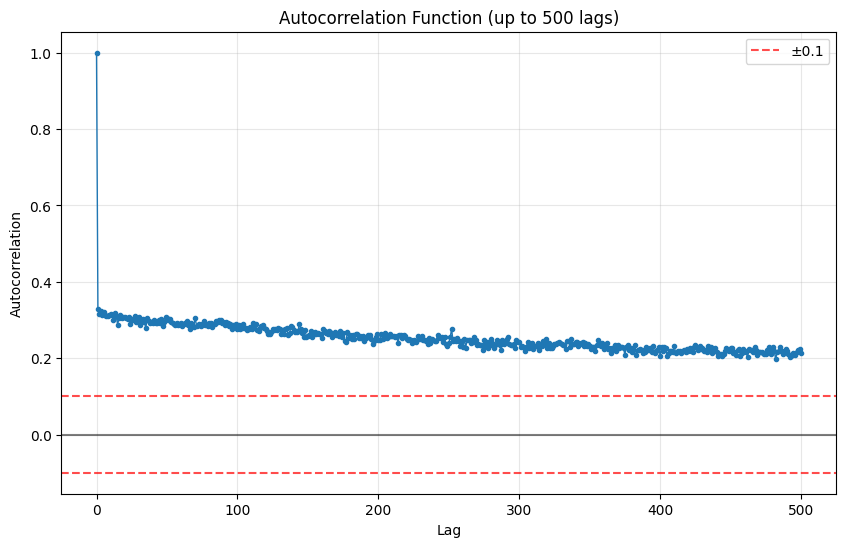

Default RMSE autocorrelation plot:


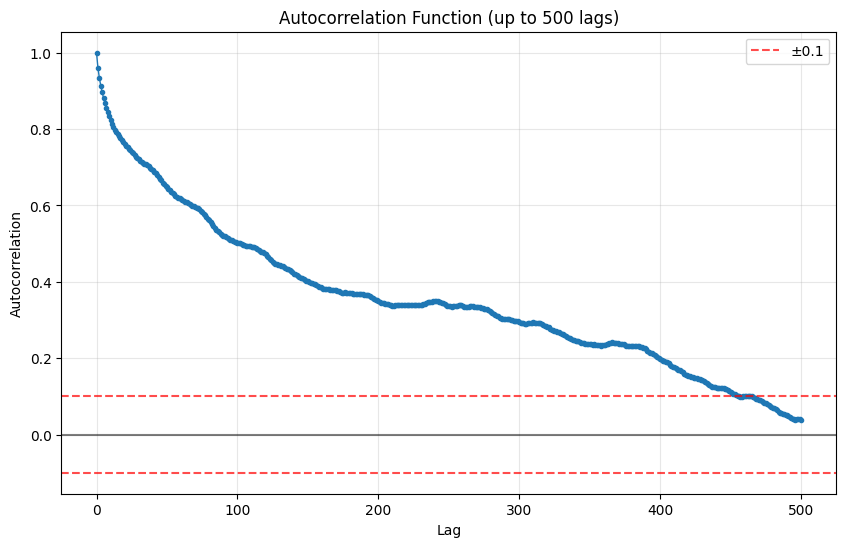


--- Run 1 ---
Default Sigma autocorrelation plot:


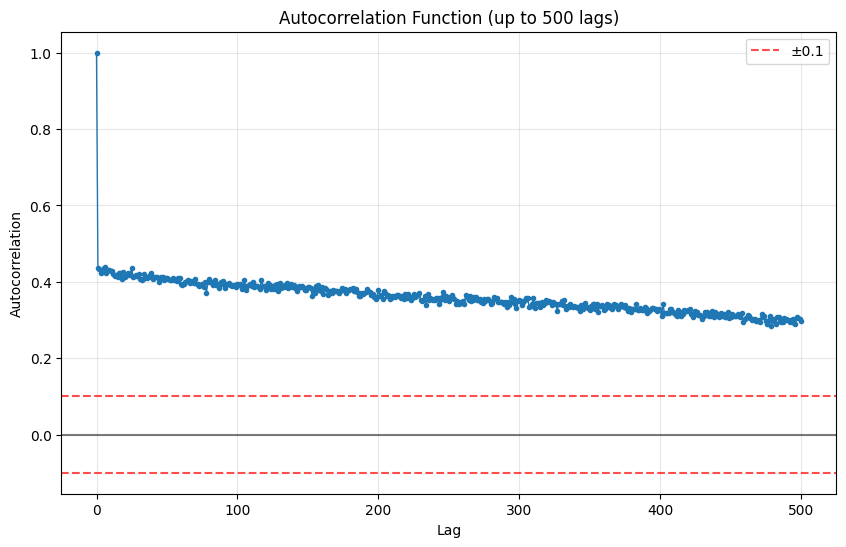

Default RMSE autocorrelation plot:


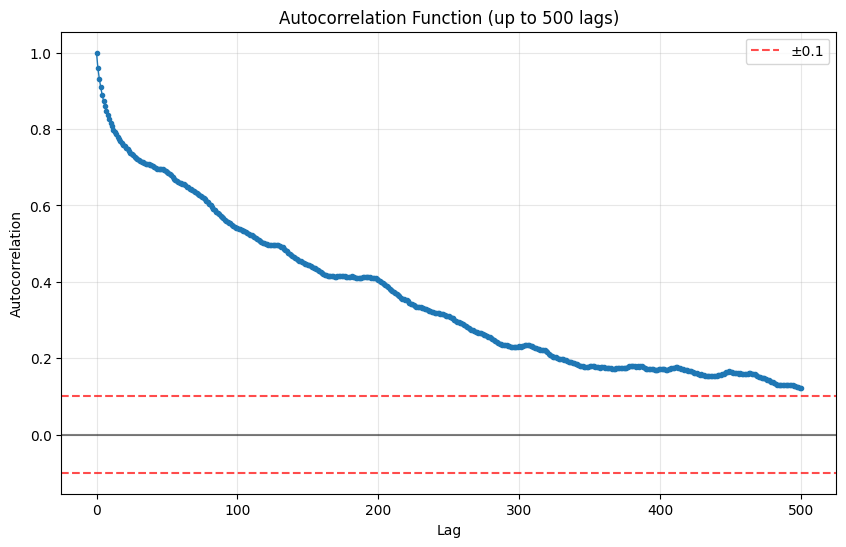


--- Run 2 ---
Default Sigma autocorrelation plot:


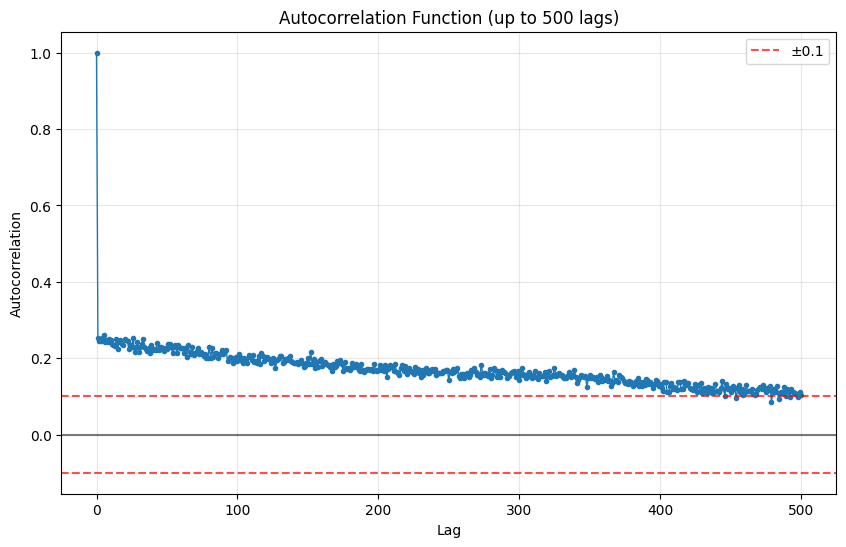

Default RMSE autocorrelation plot:


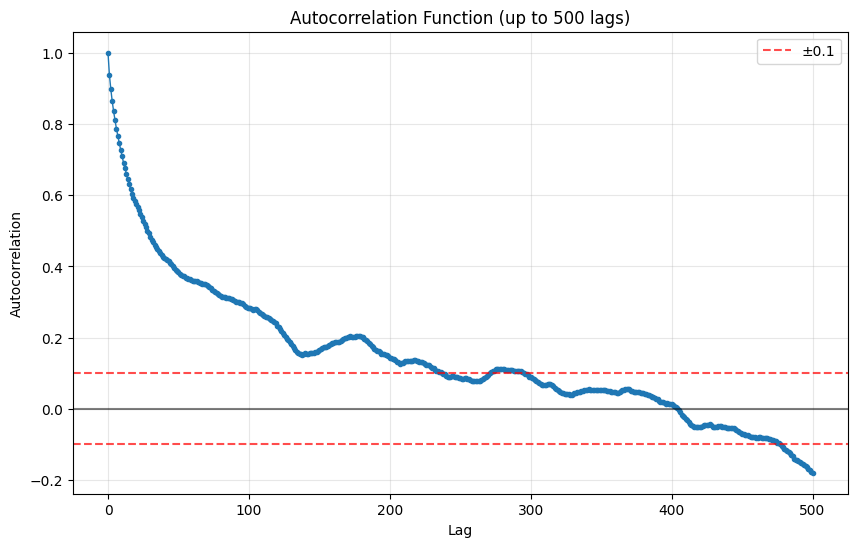


--- Run 3 ---
Default Sigma autocorrelation plot:


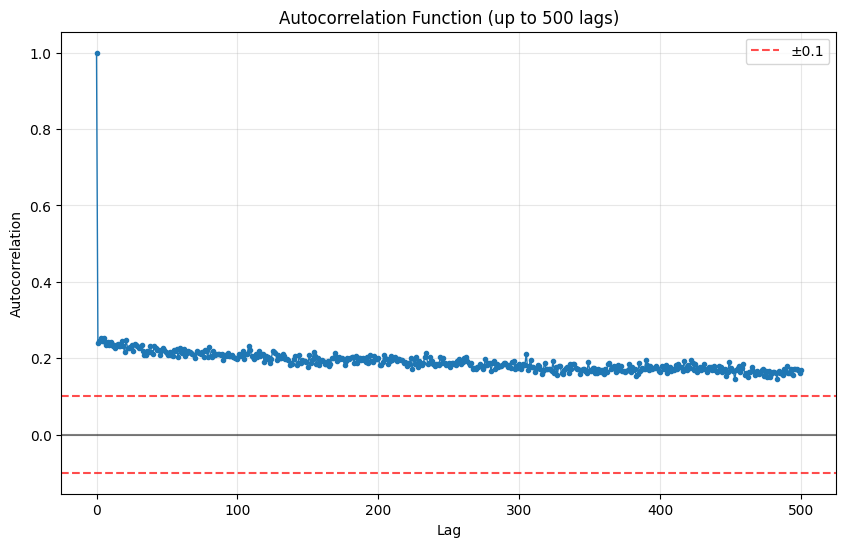

Default RMSE autocorrelation plot:


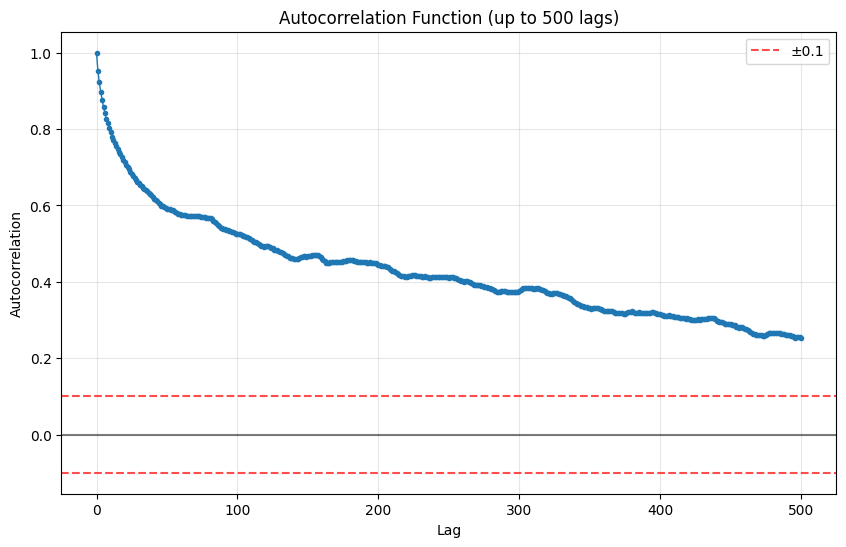

In [ ]:
# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run
    sigmas = experiment_results['default'].item()['sigmas'][run_id]
    rmses = experiment_results['default'].item()['rmses'][run_id]

    print(f"Default Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)

    print(f"Default RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)

=== MTMH BART Analysis ===

--- Run 0 ---
MTMH Sigma autocorrelation plot:


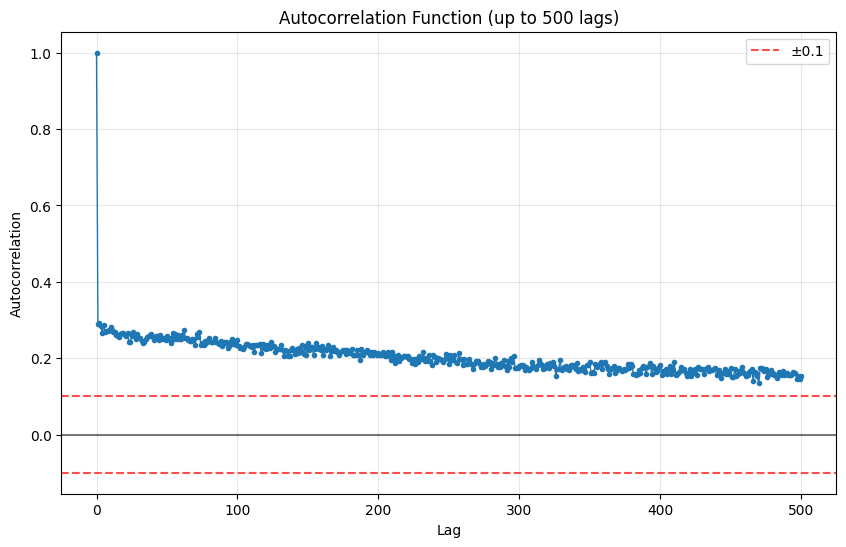

MTMH RMSE autocorrelation plot:


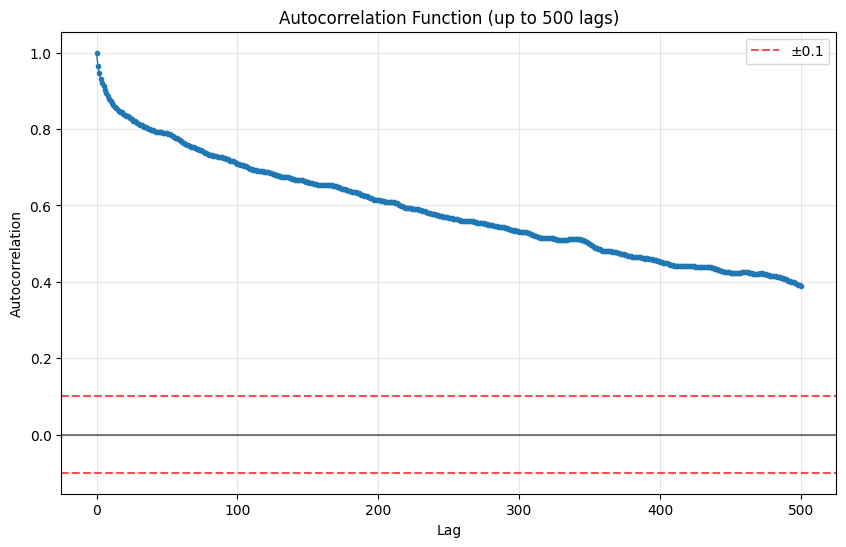


--- Run 1 ---
MTMH Sigma autocorrelation plot:


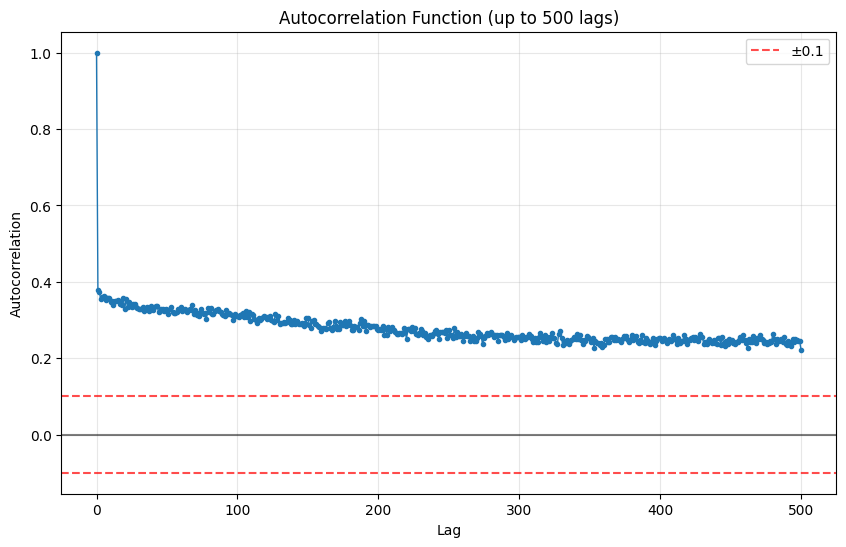

MTMH RMSE autocorrelation plot:


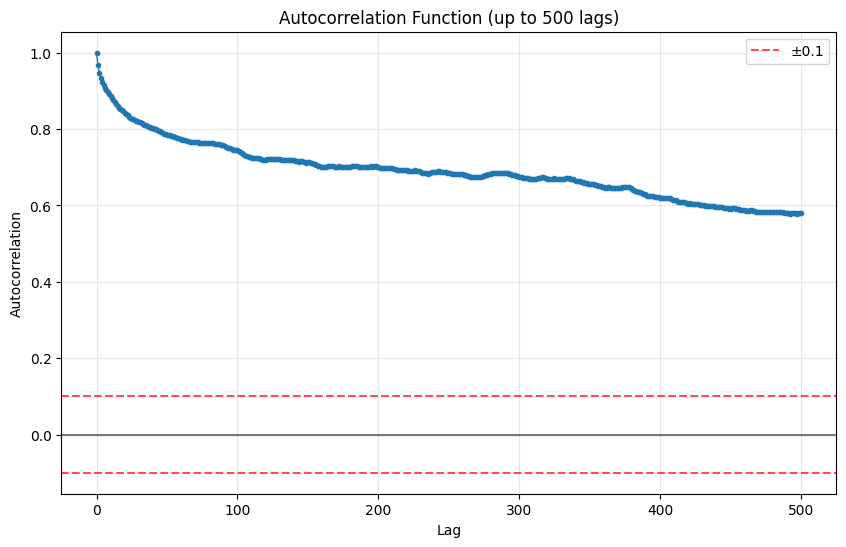


--- Run 2 ---
MTMH Sigma autocorrelation plot:


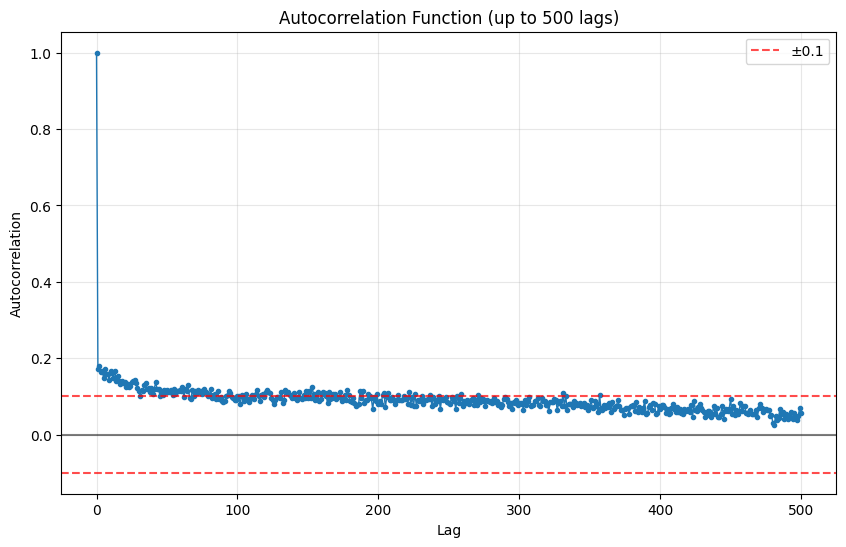

MTMH RMSE autocorrelation plot:


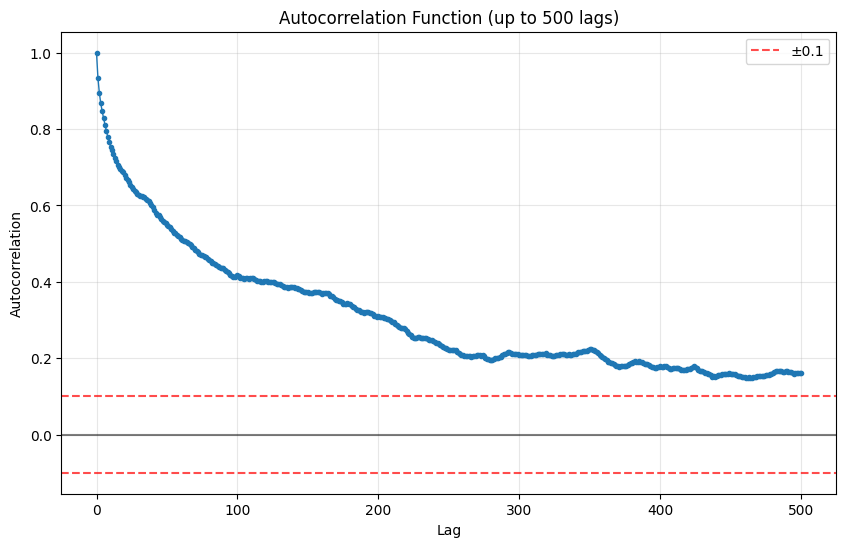


--- Run 3 ---
MTMH Sigma autocorrelation plot:


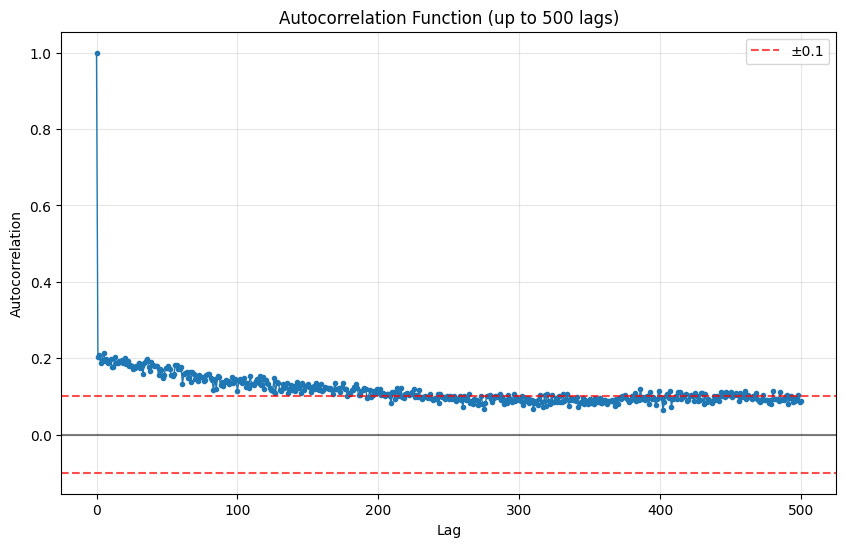

MTMH RMSE autocorrelation plot:


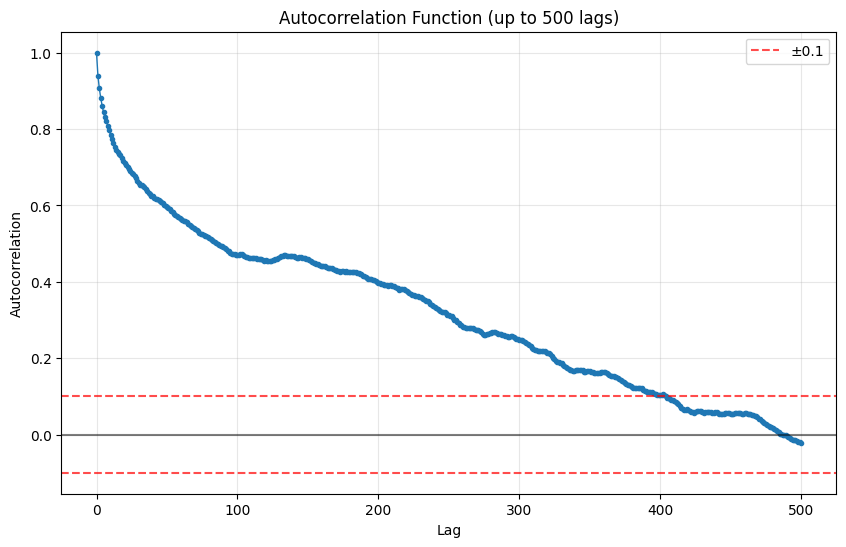

In [ ]:
# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    print(f"MTMH Sigma autocorrelation plot:")
    plot_autocorrelation(sigmas[3000:], nlags=500)

    print(f"MTMH RMSE autocorrelation plot:")
    plot_autocorrelation(rmses[3000:], nlags=500)